## Import Libraries

In [230]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import RandomOverSampler

## Import Dataset

In [231]:
data = pd.read_csv('./datasets/transfusion.data')
data.head()

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),whether he/she donated blood in March 2007
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


- **Recency**: Months since last donation
- **Frequency**: Total number of donation
- **Monetary**: Total blood donated in c.c
- **Time**: Months since first donation

In [232]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column                                      Non-Null Count  Dtype
---  ------                                      --------------  -----
 0   Recency (months)                            748 non-null    int64
 1   Frequency (times)                           748 non-null    int64
 2   Monetary (c.c. blood)                       748 non-null    int64
 3   Time (months)                               748 non-null    int64
 4   whether he/she donated blood in March 2007  748 non-null    int64
dtypes: int64(5)
memory usage: 29.3 KB


## Data Preprocessing

In [233]:
data.rename(
    columns = {
        'whether he/she donated blood in March 2007': 'blood_gave'
    }
, inplace = True)

## EDA

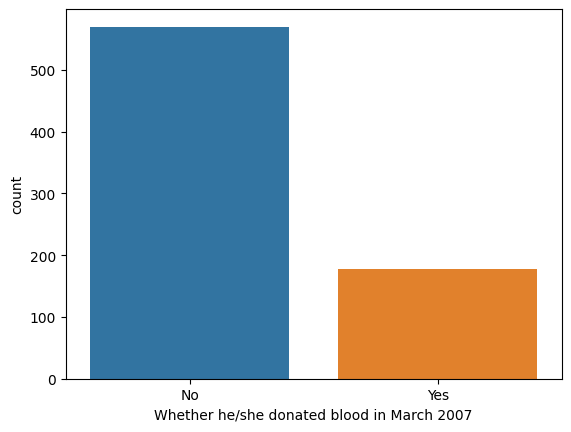

In [234]:
sns.countplot(x = 'blood_gave', data = data)
plt.xlabel("Whether he/she donated blood in March 2007")
plt.xticks((0, 1), ("No", "Yes"));

- This is clearly an imbalanced dataset

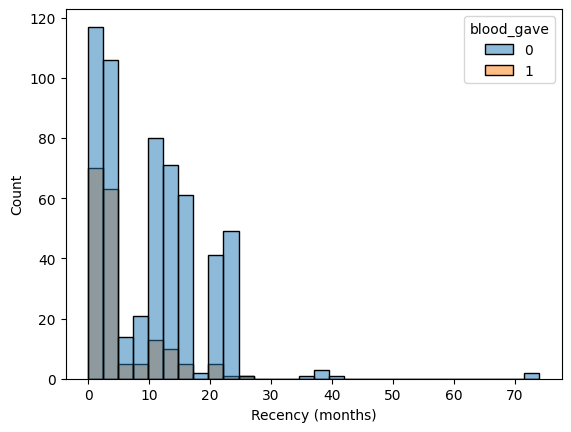

In [235]:
sns.histplot(x = "Recency (months)", data = data, hue = 'blood_gave');

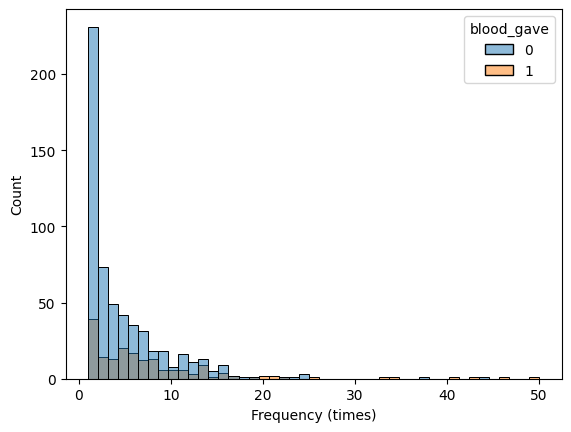

In [236]:
sns.histplot(x = "Frequency (times)", data = data, hue = 'blood_gave');

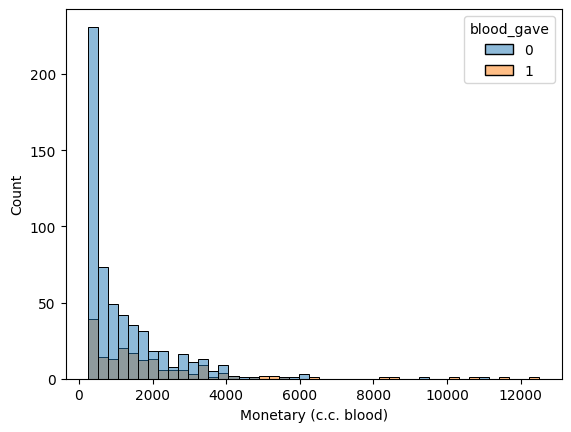

In [237]:
sns.histplot(x = "Monetary (c.c. blood)", data = data, hue = 'blood_gave');

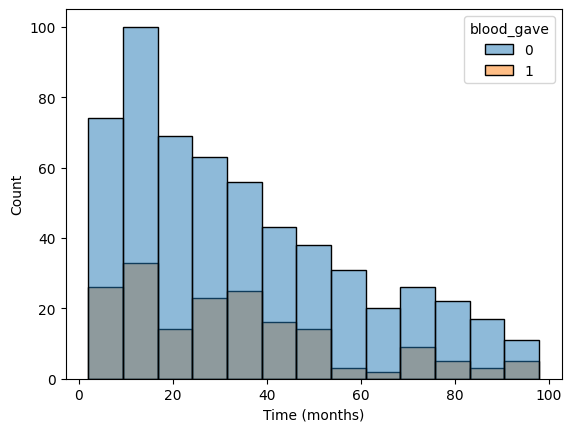

In [238]:
sns.histplot(x = "Time (months)", data = data, hue = 'blood_gave');

## Train test split

In [239]:
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

In [240]:
pd.Series(y).value_counts(normalize = True)

0    0.762032
1    0.237968
Name: proportion, dtype: float64

- Mitigating the class imbalance problem

In [241]:
over_sampler = RandomOverSampler(random_state = 1)
X, y = over_sampler.fit_resample(X, y)

In [242]:
pd.Series(y).value_counts(normalize = True)

1    0.5
0    0.5
Name: proportion, dtype: float64

In [243]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [244]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Modelling Experiments

In [245]:
def model_performance(y_test, y_pred):
    return {
        'accuracy': np.round(accuracy_score(y_test, y_pred), 2),
        'recall': np.round(recall_score(y_test, y_pred), 2),
        'precision': np.round(precision_score(y_test, y_pred), 2),
        'f1_score': np.round(f1_score(y_test, y_pred), 2),
    }

### Model1: Logistic Regression

In [246]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

y_pred = np.round(log_reg.predict(X_test))
log_reg_perf = model_performance(y_test, y_pred)
log_reg_perf

{'accuracy': 0.66, 'recall': 0.68, 'precision': 0.62, 'f1_score': 0.65}

### Model2: Decision Tree

In [247]:
dtree = DecisionTreeClassifier(random_state = 1)
dtree.fit(X_train, y_train)

y_pred = np.round(dtree.predict(X_test))
dtree_perf = model_performance(y_test, y_pred)
dtree_perf

{'accuracy': 0.8, 'recall': 0.87, 'precision': 0.74, 'f1_score': 0.8}

### Model3: Random Forest

In [248]:
rdf = RandomForestClassifier(random_state = 1)
rdf.fit(X_train, y_train)

y_pred = np.round(rdf.predict(X_test))
rdf_perf = model_performance(y_test, y_pred)
rdf_perf

{'accuracy': 0.81, 'recall': 0.88, 'precision': 0.76, 'f1_score': 0.81}

### Model4: SVM

In [249]:
svc = SVC(kernel = 'rbf')
svc.fit(X_train, y_train)

y_pred = np.round(svc.predict(X_test))
svc_perf = model_performance(y_test, y_pred)
svc_perf

{'accuracy': 0.66, 'recall': 0.64, 'precision': 0.63, 'f1_score': 0.64}

### Model5: KNN

- Finding the optimal `K` value

In [250]:
acc = []
for k in range(1, len(X_train) + 1):
    knn = KNeighborsClassifier(n_neighbors = k, n_jobs = -1)
    knn.fit(X_train, y_train)
    acc.append(accuracy_score(y_test, np.round(knn.predict(X_test))))

In [251]:
optimal_k = np.argmax(np.array(acc)) + 1    # As, index starts from 0

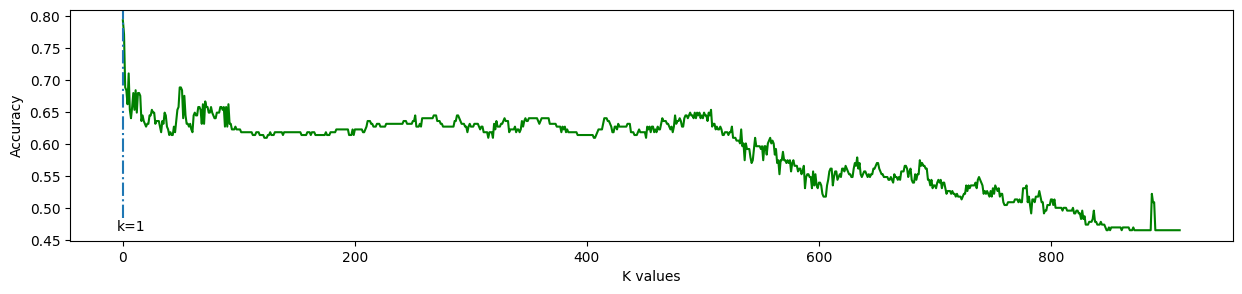

In [267]:
plt.figure(figsize = (15, 3))
sns.lineplot(acc, color = 'green')
plt.axvline(x = optimal_k - 1, linestyle = '-.', ymax = 1, ymin = 0.1)
plt.text(x = optimal_k - 6.5, y = min(acc), s = f"k={optimal_k}");
plt.xlabel("K values")
plt.ylabel("Accuracy");

In [253]:
knn = KNeighborsClassifier(n_neighbors = optimal_k, n_jobs = -1)
knn.fit(X_train, y_train)

y_pred = np.round(knn.predict(X_test))
knn_perf = model_performance(y_test, y_pred)
knn_perf

{'accuracy': 0.79, 'recall': 0.88, 'precision': 0.73, 'f1_score': 0.8}

### Model6: Naive Bayes

In [254]:
nb = GaussianNB()
nb.fit(X_train, y_train)

y_pred = np.round(nb.predict(X_test))
nb_perf = model_performance(y_test, y_pred)
nb_perf

{'accuracy': 0.65, 'recall': 0.55, 'precision': 0.64, 'f1_score': 0.59}

### Model7: Gradient Boosting

In [255]:
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)

y_pred = np.round(gb.predict(X_test))
gb_perf = model_performance(y_test, y_pred)
gb_perf

{'accuracy': 0.68, 'recall': 0.62, 'precision': 0.67, 'f1_score': 0.65}

### Model8: XGBoost

In [256]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

y_pred = np.round(xgb.predict(X_test))
xgb_perf = model_performance(y_test, y_pred)
xgb_perf

{'accuracy': 0.82, 'recall': 0.89, 'precision': 0.77, 'f1_score': 0.82}

### Model9: LightGBM

In [257]:
lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train)

y_pred = np.round(lgbm.predict(X_test))
lgbm_perf = model_performance(y_test, y_pred)
lgbm_perf

[LightGBM] [Info] Number of positive: 464, number of negative: 448
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 133
[LightGBM] [Info] Number of data points in the train set: 912, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508772 -> initscore=0.035091
[LightGBM] [Info] Start training from score 0.035091
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

{'accuracy': 0.78, 'recall': 0.82, 'precision': 0.73, 'f1_score': 0.77}

### Model10: CatBoost

In [258]:
ctb = CatBoostClassifier(verbose = 0)
ctb.fit(X_train, y_train)

y_pred = np.round(ctb.predict(X_test))
ctb_perf = model_performance(y_test, y_pred)
ctb_perf

{'accuracy': 0.75, 'recall': 0.77, 'precision': 0.71, 'f1_score': 0.74}

## Model Performance Summary

In [259]:
model_performance_df = pd.DataFrame(
    [log_reg_perf.values(),
    knn_perf.values(),
    svc_perf.values(),
    dtree_perf.values(),
    rdf_perf.values(),
    gb_perf.values(),
    nb_perf.values(),
    xgb_perf.values(),
    lgbm_perf.values(),
    ctb_perf.values()],
    columns = log_reg_perf.keys(),
    index = ["logistic_regression", "knn", "svc", "decision_tree", "random_forest", "gradient_boosting", 
             "naive_bayes", "xgboost", "light_gbm", "catboost"]
)

In [260]:
model_performance_df.sort_values(by = 'accuracy', ascending = False).style.background_gradient(cmap = 'RdYlGn')

,accuracy,recall,precision,f1_score
xgboost,0.820000,0.890000,0.770000,0.820000
random_forest,0.810000,0.880000,0.760000,0.810000
decision_tree,0.800000,0.870000,0.740000,0.800000
knn,0.790000,0.880000,0.730000,0.800000
light_gbm,0.780000,0.820000,0.730000,0.770000
catboost,0.750000,0.770000,0.710000,0.740000
gradient_boosting,0.680000,0.620000,0.670000,0.650000
logistic_regression,0.660000,0.680000,0.620000,0.650000
svc,0.660000,0.640000,0.630000,0.640000
naive_bayes,0.650000,0.550000,0.640000,0.590000


- **Best performing model** is `XGBoost` with accuracy `0.82`

In [269]:
y_pred = xgb.predict(X_test)

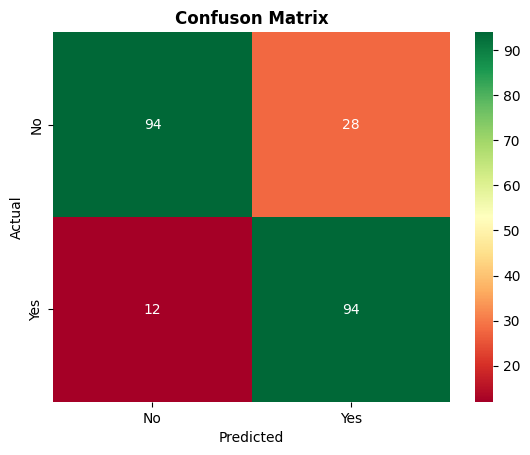

In [287]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt = 'd', cmap = 'RdYlGn')
plt.xticks((0.5, 1.5), ("No", "Yes"))
plt.yticks((0.5, 1.5), ("No", "Yes"))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confuson Matrix", fontweight = 'bold');